In [1]:
cd /Users/jz-rolling/Desktop/OMEGA_GUI/notebooks/

/Users/jz-rolling/Desktop/OMEGA_GUI/notebooks


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
from matplotlib import cm, colors
from matplotlib.gridspec import GridSpec as gs
from scipy import stats,optimize
import pickle as pk
import cloning_guru as cg

### Set working directory, load reference sheet 

In [3]:
wd = '/Volumes/JZSSD_temp/202212_Harry_flow/csv/'
ref = pd.read_excel('/Volumes/JZSSD_temp/202212_Harry_flow/20221221-well-guide.xlsx').set_index('Well')

In [4]:
gff = cg.read_gff('/Users/jz-rolling/Desktop/MycoGenomeAnalysis/references/papers/Mycobrowser/Mycobacterium_smegmatis_MC2-155_gff_v4.gff')

### define functions

In [5]:
def zscore(data):
    return (data-data.mean())/data.std()
    
def remove_outliers(df,feature='length',zcutoff=3):
    df_copied = df.copy().reset_index(drop=True)
    data =df[feature].values
    data[np.isinf(data)] = np.percentile(data,99.9)*10
    data[np.isnan(data)] = np.percentile(data,0.01)/10
    zscores = zscore(data)
    in_range = np.where(np.abs(zscores)<zcutoff)[0]
    df_filtered = df_copied.iloc[in_range].copy().sort_values(by=feature).reset_index(drop=True)
    return df_filtered

def remove_outliers_batch(df,features = ['length'],zcutoffs = [3]):
    if len(features) != len(zcutoffs):
        raise ValueError("Feature and z-cutoff lists don't match")
    df_copy = df.copy()
    for f,z in zip(features,zcutoffs):
        df_copy = remove_outliers(df_copy,f,z)
    return df_copy

def min_max(data):
    return (data-data.min())/(data.max()-data.min())

### Conflate data

In [36]:
merged = []
rep_dict ={}
for f in sorted(glob.glob(wd+'*.csv')):
    headers = f.split('/')[-1].split('export_')[1]
    well_header,_batch, time_header = headers.split('-')[:3]
    well = well_header[:-4]
    row = well[0]
    col = well[1:]
    time = time_header[:3]
    well_time_key = '{}_{}'.format(well,time)
    if well_time_key not in rep_dict:
        rep_dict[well_time_key] = 1
    else:
        rep_dict[well_time_key] += 1
    rep = rep_dict[well_time_key]
    strain_id,substrate,rapa = ref.loc[well]
    df = pd.read_csv(f)
    df['Well'] = well
    df['Column'] = col
    df['Row'] = row
    df['Time'] = time
    df['Rep'] = rep
    df['Key'] = '{}_{}_{}'.format(well,time,rep)
    df['Strain_ID'] = strain_id
    df['Substrate'] = substrate
    df['Rapamycin'] = rapa
    merged.append(df)
merged = pd.concat(merged)
merged.to_csv('/Volumes/JZSSD_temp/202212_Harry_flow/merged_csv.csv')

### Conflate and filter data

In [153]:
filtered = []
rep_dict ={}
for f in sorted(glob.glob(wd+'*.csv')):
    headers = f.split('/')[-1].split('export_')[1]
    well_header,_batch, time_header = headers.split('-')[:3]
    well = well_header[:-4]
    row = well[0]
    col = well[1:]
    time = time_header[:3]
    well_time_key = '{}_{}'.format(well,time)
    if well_time_key not in rep_dict:
        rep_dict[well_time_key] = 1
    else:
        rep_dict[well_time_key] += 1
    rep = rep_dict[well_time_key]
    strain_id,substrate,rapa = ref.loc[well]
    df = pd.read_csv(f)
    df['Well'] = well
    df['Column'] = col
    df['Row'] = row
    df['Time'] = time
    df['Rep'] = rep
    df['Key'] = '{}_{}_{}'.format(well,time,rep)
    df['Strain_ID'] = strain_id
    df['Substrate'] = substrate
    df['Rapamycin'] = rapa
    filtered.append(remove_outliers_batch(df,features=['B1-H']))
filtered = pd.concat(filtered)
filtered.to_csv('/Volumes/JZSSD_temp/202212_Harry_flow/filtered_csv.csv')

### Load saved data

In [6]:
filtered = pd.read_csv('/Volumes/JZSSD_temp/202212_Harry_flow/filtered_csv.csv')

### Group by sample

In [7]:
grouped = filtered.groupby('Key')
grouped_median = grouped.median()
grouped_median[['Well','Column','Row','Time','Rep','Strain_ID','Substrate','Rapamycin']] = grouped.max()[['Well','Column','Row','Time','Rep','Strain_ID','Substrate','Rapamycin']]
grouped_median['Time_int'] = [int(x[1:]) for x in grouped_median['Time']]

### Estimate PDF

In [14]:
xinterp = np.linspace(400,1200,200)
pdfs = []
for k in grouped_median.index:
    v = filtered[filtered['Key']==k]['B1-H'].values
    pdf = stats.gaussian_kde(v).pdf(xinterp)
    pdfs.append(pdf)
grouped_median['PDF'] = pdfs
pk.dump(grouped_median,open('/Volumes/JZSSD_temp/202212_Harry_flow/filtered_grouped.pk','wb'))

In [8]:
grouped_median = pk.load(open('/Volumes/JZSSD_temp/202212_Harry_flow/filtered_grouped.pk','rb'))

### Create individual histograms

In [33]:
times = ['t0','t3','t6','t9']
time_labels = ['0 hrs','3 hrs','6 hrs','9 hrs']
bg_color=np.array([40,40,40])/255
ctrl_color=np.array([121,121,121])/255
rapa_color=np.array([225,60,80])/255
vmin=450
xinterp = np.linspace(400,1200,200)

for i,substrate in enumerate(grouped_median['Substrate'].unique()):
    if substrate not in['RpoA-plateend','FtsH','ClpB','GlgE','Ctrl1','Ctrl2']:
        fig=plt.figure(figsize=(4,4))
        ax =fig.add_subplot()
        ctrl_minus = grouped_median[(grouped_median['Substrate']=='Ctrl1')&\
                              (grouped_median['Rep']==1)&\
                              (grouped_median['Rapamycin']=='-')]
        ctrl_plus = grouped_median[(grouped_median['Substrate']=='Ctrl1')&\
                              (grouped_median['Rep']==1)&\
                              (grouped_median['Rapamycin']=='+')]

        subset = grouped_median[(grouped_median['Substrate']==substrate)].copy()
        vmin = 450
        vmax = round(subset['B1-H'].max(),-2)+120
        plot_range = np.where((xinterp>vmin)&(xinterp<vmax))[0]
        sliced_x = xinterp[plot_range]
        for i,t in enumerate(times):
            for j,r in enumerate([1,2]):
                rapa_plus = min_max(subset[(subset['Rapamycin']=='+')&(subset['Time']==t)&(subset['Rep']==r)]['PDF'].values[0])[plot_range]
                rapa_minus = min_max(subset[(subset['Rapamycin']=='-')&(subset['Time']==t)&(subset['Rep']==r)]['PDF'].values[0])[plot_range]
                
                ax.plot(sliced_x,rapa_minus+i*1.1,color=ctrl_color,zorder=3)
                ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_minus+i*1.1,color=ctrl_color,alpha=0.2,zorder=3)
                ax.plot(sliced_x,rapa_plus+i*1.1,color=rapa_color,zorder=2)
                ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,y2=rapa_plus+i*1.1,color=rapa_color,alpha=0.2,zorder=2)
                
                
            ctrl1 = min_max(ctrl_minus[ctrl_minus['Time']==t]['PDF'].values[0])[plot_range]
            ctrl2 = min_max(ctrl_plus[ctrl_plus['Time']==t]['PDF'].values[0])[plot_range]
            ax.plot(sliced_x,ctrl1+i*1.1,color=bg_color,ls=':',zorder=1)
            ax.plot(sliced_x,ctrl2+i*1.1,color=bg_color,ls=':',zorder=1)
            #ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
            #                y2=ctrl1+i*1.1,color=bg_color,alpha=0.05)
            #ax.fill_between(sliced_x,y1=np.zeros(len(sliced_x))+i*1.1,
            #                y2=ctrl2+i*1.1,color=bg_color,alpha=0.05)
            ax.hlines(y=[i*1.1 for i in range(4)],xmin=vmin+1,xmax=vmax-1,color='w',zorder=5,lw=2)
            ax.hlines(y=[i*1.1 for i in range(4)],xmin=vmin,xmax=vmax,color='black',zorder=6,lw=1)
        
        ax.set_xlim(vmin,vmax)
        ax.set_yticks([])
        ax.set_xticklabels([int(x) for x in ax.get_xticks()],fontsize=14)
        for i in range(4):
            y = i*1.1+0.85
            x = vmin+(vmax-vmin)/40
            ax.text(x,y,time_labels[i],ha='left',va='center',fontsize=14)
        ax.set_title(substrate,fontsize=16,fontname='Helvetica')
        plt.savefig('/Volumes/JZSSD_temp/202212_Harry_flow/figures/{}_flowchart.svg'.format(substrate),bbox_inches='tight')
        plt.close()
        #break

/Users/jz-rolling/Desktop/OMEGA_GUI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jz-rolling/Desktop/OMEGA_GUI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jz-rolling/Desktop/OMEGA_GUI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jz-rolling/Desktop/OMEGA_GUI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jz-rolling/Desktop/OMEGA_GUI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jz-rolling/Desktop/OMEGA_GUI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used togethe

### Set background fluorescence

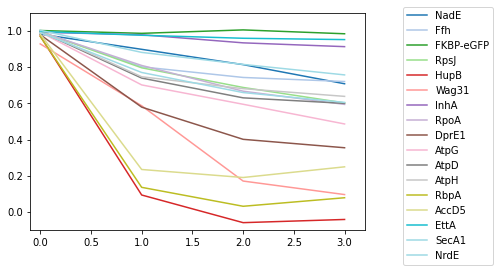

In [542]:
bg_dmso = grouped_median[(grouped_median['Substrate']=='Ctrl2')&\
                         (grouped_median['Rapamycin']=='-')].copy().groupby('Time').mean().loc[['t0','t3','t6','t9']]['B1-H'].values
bg_rapa = grouped_median[(grouped_median['Substrate']=='Ctrl2')&\
                         (grouped_median['Rapamycin']=='+')].copy().groupby('Time').mean().loc[['t0','t3','t6','t9']]['B1-H'].values

p0 = [1]
def unit_monoExp(x, t):
    return np.exp(-t * x)
xinterp=np.linspace(0,3.2,100)
fit_list = []

fig=plt.figure(figsize=(6,4))
for i,substrate in enumerate(grouped_median['Substrate'].unique()):
    if substrate not in['RpoA-plateend','FtsH','ClpB','GlgE','Ctrl1','Ctrl2']:
        subset = grouped_median[grouped_median['Substrate']==substrate].copy()
        v1 = subset[subset['Rapamycin']=='-'].copy().groupby('Time').mean().loc[['t0','t3','t6','t9']]['B1-H'].values
        v2 = subset[subset['Rapamycin']=='+'].copy().groupby('Time').mean().loc[['t0','t3','t6','t9']]['B1-H'].values
        norm_v = (v2-bg_rapa)/(v1-bg_dmso)
        p,_e = optimize.curve_fit(unit_monoExp,np.arange(4),norm_v,p0=p0,bounds=[[0],[50]])
        plt.plot(norm_v,label=substrate,color=cm.get_cmap('tab20')(i))
        fit_list.append([substrate,p[0],norm_v,unit_monoExp(xinterp,p[0]),v1[0]])
substrate_stat = pd.DataFrame(fit_list,columns=['Substrate','deg_rate','normalized_degradation','fitted_degradation','steady_state_intensity'])
plt.ylim(-0.1,1.1)
plt.xlim(-0.1,3.2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [543]:
pk.dump(substrate_stat,open('/Volumes/JZSSD_temp/202212_Harry_flow/substrate_stat_new.pk','wb'))

### Plot individual fit plots

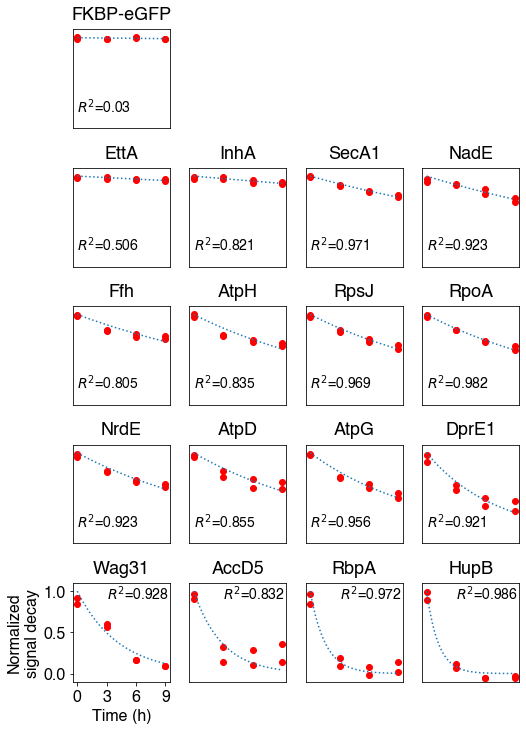

In [318]:
fig=plt.figure(figsize=(8,12))
grids= gs(5,4,hspace=0.4)

decay_rate = np.zeros(len(substrate_stat))

for i,k in enumerate(np.argsort(substrate_stat['deg_rate'])):
    substrate = substrate_stat['Substrate'].values[k]
    if i==0:
        r,c = 0,0
    else:
        r,c = int((i-1)/4)+1,(i-1)%4
    ax=fig.add_subplot(grids[r,c])
    if r==4 and c==0:
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels(['0.0','0.5','1.0'],fontsize=16,fontname='Helvetica')
        ax.set_xticks([0,3,6,9])
        ax.set_xticklabels([0,3,6,9],fontsize=16,fontname='Helvetica')
        ax.set_xlabel('Time (h)',fontsize=16,fontname='Helvetica')
        ax.set_ylabel('Normalized\nsignal decay',fontsize=16,fontname='Helvetica')
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax,p=plot_fit(ax,substrate)
    decay_rate[k]=p[0]
    ax.set_title(substrate,va='bottom',fontsize=18,fontname='Helvetica')
substrate_stat['deg_rate']=decay_rate
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_flow/decay_fit.svg',bbox_inches='tight')

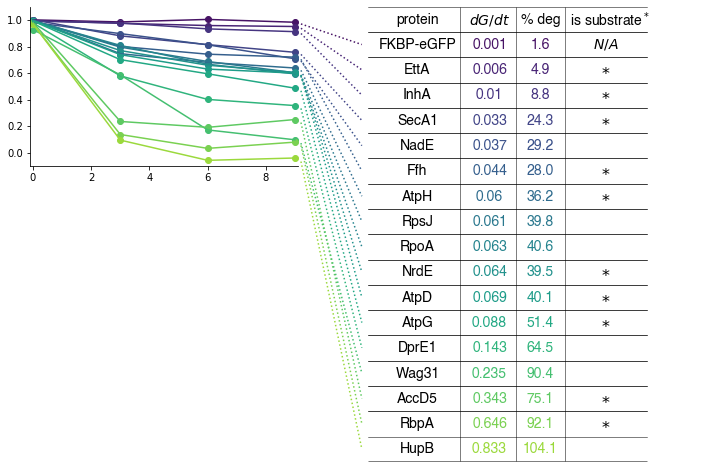

In [466]:
fig=plt.figure(figsize=(12,12))
grids = gs(20,10,wspace=0)
ax1=fig.add_subplot(grids[:5,:4])
ax2=fig.add_subplot(grids[:-6,4])
ax2.axis('off')
ax3=fig.add_subplot(grids[:-6,5:])
ax3.set_yticks([])
ax3.set_xticks([])
ax2.set_ylim(-0.34,2.1)
ax3.set_ylim(-0.34,2.1)
ax3_step = (2.1+0.34)/18
ax1.spines[['right', 'top']].set_visible(False)
ax3.spines[['left', 'right','top','bottom']].set_visible(False)
ax3.text(0.15,15*ax3_step,'protein',va='center',ha='center',fontsize=14,fontname='Helvetica',fontweight='bold')
ax3.text(0.37,15*ax3_step,'$dG/dt$',va='center',ha='center',fontsize=14,fontname='Helvetica',fontweight='bold')
ax3.text(0.525,15*ax3_step,'% deg',va='center',ha='center',fontsize=14,fontname='Helvetica',fontweight='bold')
ax3.text(0.615,15*ax3_step,'is substrate$^*$',va='center',ha='left',fontsize=14,fontname='Helvetica',fontweight='bold')
is_substrate = np.ones(len(substrate_stat))
is_substrate[np.array([4,7,8,12,13,16])] = 0
is_substrate[0] = -1

for i,k in enumerate(np.argsort(substrate_stat['deg_rate'])):
    substrate,deg,raw_deg = substrate_stat[['Substrate','deg_rate','normalized_degradation']].values[k]
    color = cm.get_cmap('viridis')((i+1)/20)
    ax1.plot(np.array([0,3,6,9]),raw_deg,color=color)
    ax1.scatter(np.array([0,3,6,9]),raw_deg,color=color)
    ax2.plot([0,0.85],[raw_deg[-1]*0.72+1.3,(14-i)*ax3_step],color=color,ls=':')
    ax3.plot([0,0.85],[2.1-i*ax3_step,2.1-i*ax3_step],color='black',lw=0.5)
    ax3.text(0.15,(14-i)*ax3_step,substrate,va='center',ha='center',fontsize=14,fontname='Helvetica')
    ax3.text(0.37,(14-i)*ax3_step,round(deg,3),va='center',ha='center',fontsize=14,fontname='Helvetica',color=color)
    ax3.text(0.525,(14-i)*ax3_step,round((1-np.min(raw_deg[-1]))*100,1),va='center',ha='center',fontsize=14,fontname='Helvetica',color=color)
    if is_substrate[i]==-1:
        ax3.text(0.725,(14-i)*ax3_step,'$N/A$',va='center',ha='center',fontsize=14,fontname='Helvetica')
    if is_substrate[i]==1:
        ax3.text(0.725,(13.9-i)*ax3_step,'$*$',va='center',ha='center',fontsize=16,fontname='Helvetica')
    ax3.plot([0,0.85],[2.1-(i+1)*ax3_step,2.1-(i+1)*ax3_step],color='black',lw=0.5)
ax3.vlines(0.28,-0.338,2.1,lw=0.5,color='black')
ax3.vlines(0.45,-0.338,2.1,lw=0.5,color='black')
ax3.vlines(0.6,-0.338,2.1,lw=0.5,color='black')
ax3.hlines(-0.338,0,0.85,lw=0.5,color='black')
ax3.set_xlim(-0.01,1.01)
ax1.set_xlim(-0.1,9.1)
ax1.set_ylim(-0.1,1.1)
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_flow/decay_fit_stat.svg',bbox_inches='tight')

In [396]:
def iupred_reader(file):
    f = open(file,'r')
    iupred = []
    while True:
        line = f.readline().rstrip()
        if len(line)==0:
            break
        if not line.startswith('#'):
            score = line.split('\t')
            iupred.append(float(score[2]))
    f.close()
    return np.array(iupred)

In [497]:
iupred = []
deg_rate = []
ssis = []
for s,deg,ssi in substrate_stat[['Substrate','deg_rate','steady_state_intensity']].values:
    if s not in ['Wag31','HupB','FKBP-eGFP']:
        score = iupred_reader('/Volumes/JZSSD_temp/202212_Harry_flow/IUpred/{}.txt'.format(s))
        iupred.append(np.mean(score))
        deg_rate.append(deg)
        ssis.append(ssi)
        #plt.scatter(ssi,)

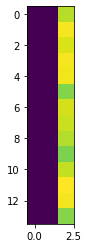

In [498]:
plt.imshow(np.array([iupred,deg_rate,ssis]).T)

In [499]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [500]:
mm=PCA(n_components=2).fit_transform(StandardScaler().fit_transform(np.array([iupred,deg_rate,ssis]).T))

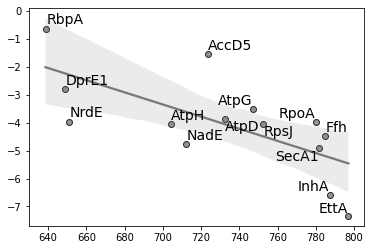

In [540]:
from adjustText import adjust_text
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot()
g=sns.regplot(x=ssis,y=np.log2(deg_rate),color=np.array([121,121,121])/255,scatter_kws={'ec':'black'},ax=ax)
texts = []
for s,deg,ssi in substrate_stat[['Substrate','deg_rate','steady_state_intensity']].values:
    if s not in ['Wag31','HupB','FKBP-eGFP']:
        texts.append(ax.text(ssi,np.log2(deg),s,fontsize=14,ha='left',va='bottom'))
adjust_text(texts)
plt.xlim(630,805)
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_flow/intensity_deg.svg',bbox_inches='tight')

In [115]:
from sklearn.metrics import r2_score


def unit_monoExp(x, t):
    return np.exp(-t * x)


def plot_fit(ax,substrate,raw_color='r',fit_color='black'):
    xinterp=np.linspace(0,9,100)
    fit_list = []
    subset = grouped_median[grouped_median['Substrate']==substrate].copy()

    # calculate pos control mean values
    v1 = subset[subset['Rapamycin']=='-'].copy().groupby('Time').mean().loc[['t0','t3','t6','t9']]['B1-H']

    # get exp data
    v2 = []
    for t in v1.index:
        v2.append(subset[(subset['Rapamycin']=='+')&(subset['Time']==t)]['B1-H'].values[:2])
    v2 = np.array(v2)

    # normalize to bg
    norm_v2 = (v2-bg_rapa[:,np.newaxis])/((v1.values-bg_dmso)[:,np.newaxis])
    mean_v = norm_v2.mean(axis=1)
    std_v = norm_v2.std(axis=1)
    
    # plot
    ax.scatter(np.array([0,3,6,9]),norm_v2[:,0],color=raw_color)
    ax.scatter(np.array([0,3,6,9]),norm_v2[:,1],color=raw_color)
    
    # fit
    p0 = [1]
    p,_e = optimize.curve_fit(unit_monoExp,np.array([0,3,6,9]),mean_v,p0=p0,bounds=[[0],[150]])
    ax.plot(xinterp,unit_monoExp(xinterp,p[0]),ls=':')
    ax.set_ylim(-0.1,1.1)
    r2 = round(r2_score(mean_v, unit_monoExp(np.array([0,3,6,9]),p[0])),3)
    if mean_v[2]>0.4:
        ax.text(0,0.1,'$R^2$={}'.format(r2),fontsize=14,fontname='Helvetica')
    else:
        ax.text(3,0.9,'$R^2$={}'.format(r2),fontsize=14,fontname='Helvetica')
    return ax,p

### Process FKBP GFP data

In [39]:
prev = []
rep_dict ={}

for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_flow/flow-csv-Fig2/*.csv')):
    headers = f.split('/')[-1].split('export_')[1]
    well,_batch, time_header = headers.split('-')[:3]
    row = well[0]
    col = well[1:]
    if well not in rep_dict:
        rep_dict[well] = 1
    else:
        rep_dict[well] += 1
    
    rep = rep_dict[well]
    df = pd.read_csv(f)
    df['Well'] = well
    df['Column'] = col
    df['Row'] = row
    df['Time'] = '24h'
    df['Rep'] = 1
    prev.append(remove_outliers_batch(df,features=['AF488-H']))
prev = pd.concat(prev)
#filtered.to_csv('/Volumes/JZSSD_temp/202212_Harry_flow/filtered_csv.csv')

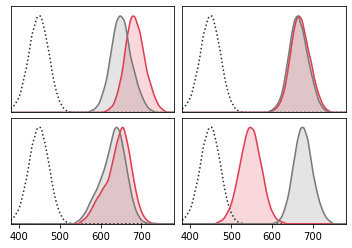

In [79]:
xinterp = np.linspace(380,780,200)
pdfs = {}
for w in prev['Well'].unique():
    v = prev[prev['Well']==w]['AF488-H'].values
    pdf = stats.gaussian_kde(v).pdf(xinterp)
    pdf = (pdf-pdf.min())/(pdf.max()-pdf.min())
    pdfs[w]=pdf
    
fig=plt.figure(figsize=(6,4))
grids = gs(2,2,hspace=0.05,wspace=0.05)
ax1 = fig.add_subplot(grids[0,0])
ax2 = fig.add_subplot(grids[0,1])
ax3 = fig.add_subplot(grids[1,0])
ax4 = fig.add_subplot(grids[1,1])


top_left=['B10','E9','C9']
top_right=['B10','E6','C6']
bot_left=['B10','D9','B9']
bot_right=['B10','D6','B6']
colors = [np.array([40,40,40])/255,np.array([225,60,80])/255,np.array([121,121,121])/255]
lws = [':','-','-']
alphas = [0,0.2,0.2]

for i in range(3):
    ax1.plot(xinterp,pdfs[top_left[i]],color=colors[i],ls=lws[i])
    ax1.fill_between(xinterp,np.zeros(len(xinterp)),pdfs[top_left[i]],color=colors[i],alpha=alphas[i])
    ax2.plot(xinterp,pdfs[top_right[i]],color=colors[i],ls=lws[i])
    ax2.fill_between(xinterp,np.zeros(len(xinterp)),pdfs[top_right[i]],color=colors[i],alpha=alphas[i])
    ax3.plot(xinterp,pdfs[bot_left[i]],color=colors[i],ls=lws[i])
    ax3.fill_between(xinterp,np.zeros(len(xinterp)),pdfs[bot_left[i]],color=colors[i],alpha=alphas[i])
    ax4.plot(xinterp,pdfs[bot_right[i]],color=colors[i],ls=lws[i])
    ax4.fill_between(xinterp,np.zeros(len(xinterp)),pdfs[bot_right[i]],color=colors[i],alpha=alphas[i])
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlim(380,780)
    ax.set_yticks([])
    ax.set_ylim(0,1.1)
    ax.set_xticks([400,500,600,700])
for ax in [ax1,ax2]:
    ax.set_xticks([])
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_flow/flow_demo.svg',bbox_inches='tight')